# About

This notebook builds a IR ranking system using word2vec.
 
1. Generates word2vec embeddings using the Train set query and passages
2. Get word2vec vectors for Test set's query and passages using embeddings learned from Train set
3. Calculate cosine similarity between each query, passage pair in Test set. 
4. For each query, rank the 20 passages based on similarity scores.
5. Evaluate the IR ranking system by the top 10 ranked passages for each query in the Test set.

reference: https://www.analyticsvidhya.com/blog/2020/08/information-retrieval-using-word2vec-based-vector-space-model/

# Load libraries

In [58]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
#from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

# Load Train Test queries and passages

In [17]:
# query
query_train = pd.read_csv("./output/query_train_set_with_passage_info.csv")
query_test =pd.read_csv("./output/query_test_set_with_passage_info.csv")

# passage
passage_train = pd.read_csv("./output/train_passage_id_content_cleaned.csv")
passage_test = pd.read_csv("./output/test_passage_id_content_cleaned.csv")

In [3]:
print(query_train.shape)
print(query_test.shape)
print(passage_train.shape)
print(passage_test.shape)

(20000, 9)
(20000, 9)
(19920, 4)
(19854, 4)


In [4]:
display(query_train.head())
display(query_test.head())
display(passage_train.head())
display(passage_test.head())

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned
0,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_62_547459701,1,16.102699,Anserini,1,what are the characteristics of wool fibres
1,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_21_588232716,2,14.784700,Anserini,1,what are the characteristics of wool fibres
2,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_11_97323294,3,13.865800,Anserini,1,what are the characteristics of wool fibres
3,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_68_54887603,4,13.865799,Anserini,1,what are the characteristics of wool fibres
4,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_62_547466749,5,13.793600,Anserini,1,what are the characteristics of wool fibres


,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned
0,203324,him functions to the paper health record,Q0,msmarco_passage_49_115778700,1,13.2671,Anserini,1,him functions to the paper health record
1,203324,him functions to the paper health record,Q0,msmarco_passage_26_450017756,2,11.8537,Anserini,1,him functions to the paper health record
2,203324,him functions to the paper health record,Q0,msmarco_passage_19_202396335,3,11.2738,Anserini,1,him functions to the paper health record
3,203324,him functions to the paper health record,Q0,msmarco_passage_28_623516004,4,11.0361,Anserini,1,him functions to the paper health record
4,203324,him functions to the paper health record,Q0,msmarco_passage_02_47181174,5,10.9476,Anserini,1,him functions to the paper health record


,passage_id,passage,passage_cleaned,passage_cleaned_lemmatized
0,msmarco_passage_62_547459701,Table of Contents. Growth. Harvesting. Grading...,table of contents growth harvesting grading of...,table content growth harvesting grade wool fib...
1,msmarco_passage_21_588232716,A micron ( micrometre) is the measurement used...,a micron micrometre is the measurement used to...,micron micrometre measurement express diameter...
2,msmarco_passage_11_97323294,Objective measurements include diameter (micro...,objective measurements include diameter micron...,objective measurement include diameter micron ...
3,msmarco_passage_68_54887603,Objective measurements include diameter (micro...,objective measurements include diameter micron...,objective measurement include diameter micron ...
4,msmarco_passage_62_547466749,Summary of Characteristics of Wool Fibers. Woo...,summary of characteristics of wool fibers wool...,summary characteristic wool fiber wool protein...


,passage_id,passage,passage_cleaned,passage_cleaned_lemmatized
0,msmarco_passage_49_115778700,"This information can be either paper-based, a ...",this information can be either paper based a c...,information paper base combination paper digit...
1,msmarco_passage_26_450017756,Hybrid Health Record. Electronic Health Record...,hybrid health record electronic health records...,hybrid health record electronic health record ...
2,msmarco_passage_19_202396335,Health information management ( HIM) is inform...,health information management him is informati...,health information management information mana...
3,msmarco_passage_28_623516004,Documentation for Health Records addresses iss...,documentation for health records addresses iss...,documentation health record address issue rela...
4,msmarco_passage_02_47181174,The influence of this growing shift toward tec...,the influence of this growing shift toward tec...,influence grow shift technology feel industry ...


# Train set - combine queries with passage

In [5]:
passage_train.rename(columns={"passage_cleaned_lemmatized":"text"}).head()

,passage_id,passage,passage_cleaned,text
0,msmarco_passage_62_547459701,Table of Contents. Growth. Harvesting. Grading...,table of contents growth harvesting grading of...,table content growth harvesting grade wool fib...
1,msmarco_passage_21_588232716,A micron ( micrometre) is the measurement used...,a micron micrometre is the measurement used to...,micron micrometre measurement express diameter...
2,msmarco_passage_11_97323294,Objective measurements include diameter (micro...,objective measurements include diameter micron...,objective measurement include diameter micron ...
3,msmarco_passage_68_54887603,Objective measurements include diameter (micro...,objective measurements include diameter micron...,objective measurement include diameter micron ...
4,msmarco_passage_62_547466749,Summary of Characteristics of Wool Fibers. Woo...,summary of characteristics of wool fibers wool...,summary characteristic wool fiber wool protein...


## Treat passage that get null after lemmatization

In [11]:
passage_train[passage_train["passage_cleaned_lemmatized"].isnull()]

,passage_id,passage,passage_cleaned,passage_cleaned_lemmatized


In [12]:
passage_test[passage_test["passage_cleaned_lemmatized"].isnull()]

,passage_id,passage,passage_cleaned,passage_cleaned_lemmatized
6900,msmarco_passage_25_423645543,what's your take on that. what's yours. What's...,what is your take on that what is yours what i...,NaN


In [18]:
passage_test["passage_cleaned_lemmatized"] = np.where(passage_test["passage_cleaned_lemmatized"].isnull(),passage_test["passage_cleaned"], passage_test["passage_cleaned_lemmatized"] )

In [20]:
passage_test[passage_test["passage_cleaned_lemmatized"].isnull()]

,passage_id,passage,passage_cleaned,passage_cleaned_lemmatized


# Combine corpus and queries for training

In [21]:
# Combining corpus and queries for training
combined_training = (pd.concat([passage_train.rename(columns={"passage_cleaned_lemmatized":"text"})["text"],
                             query_train.rename(columns={"query_cleaned":'text'})['text']])
                             .sample(frac=1) #shuffle
                             .reset_index(drop=True))
print(passage_train.shape)
print(query_train.shape)
print(combined_training.shape)
display(combined_training.head())


(19920, 4)
(20000, 9)
(39920,)


0    english language learner definition signatory ...
1                                  age for millennials
2    cook till liter slow cook concentrated liter f...
3               the type of waste in most landfills is
4                        foods that contain fiber list
Name: text, dtype: object

In [22]:
# Creating data for the model training
train_data=[]
for i in combined_training:
    train_data.append(i.split())

# Training a word2vec model from the given data set
w2v_model = Word2Vec(train_data
                     , vector_size = 300
                     , min_count = 2
                     , window = 5
                     , sg = 1
                     , workers = 4)

In [23]:
# Vocabulary size
print('Vocabulary size:', len(w2v_model.wv))

Vocabulary size: 19671


In [24]:
# Function returning vector reperesentation of a document
def get_embedding_w2v(doc_tokens):
    embeddings = []
    if len(doc_tokens)<1:
        return np.zeros(300)
    else:
        for tok in doc_tokens:
            if tok in w2v_model.wv:
                embeddings.append(w2v_model.wv.get_vector(tok))
            else:
                embeddings.append(np.random.rand(300))
        # mean the vectors of individual words to get the vector of the document
        return np.mean(embeddings, axis=0)



In [25]:
"hello" in w2v_model.wv

True

In [26]:
len(w2v_model.wv.get_vector("hello"))

300

# Prepare input for Test Set's Evaluation

In [27]:
def create_data_for_inference(query_df, passage_df):
    """
    # this function for loop each query, create list_query_passage (a list of list) for every query: [[query1, passage1], [query1, passage2] ....]
    # then pass this query's list_query_passage to model to make prediction, each query will return a score (list): [score1, score2, score3 ....]
    # the ouput dict_qid_all_prediction is a dictionary that append all query's list_score: {qid1: [score1, score2, score3 ....]}
    # the ouput dict_qid_pid_true is a dictionary that append all query's True ranked qassage {qid1: [pid1, pid2, ..., pid of topn]}
    """

    # create a list of list for all queries [[query1, passage1], [query1, passage2]..., [query2, passage1], [query2, passage2]..., ]
    # This would be used to fit into model to make prediction
    list_query_passage = []


    # create a list of list for all queries [[qid1, pid1], [qid1, pid2]..., [qid2, pid1], [qid2, pid2]..., ]
    # This would be used to collect and sort model prediction
    list_qid_all_pid = []

    # create a dict of dict for all queries {qid1: {pid1: rel, pid2: rel, ...}, qid2: {pid1: rel, pid2: rel, ...}, }
    # This would be used to evaluate model prediction
    dict_of_dict_qid_pid_rel = {}

    # iterate over all qid
    list_qid = query_df["query_id"].unique()
    for qid in list_qid:

        
        # get the rows that contains the qid, pid, score, rel for this qid
        query_df_subset = query_df[query_df['query_id'] == qid]
        
        # iterate over all pid
        for index, row in query_df_subset.iterrows():
            
            # create a list of 2 elements [query, passage]
            list = []
            list.append(row['query'])

            # get the only 1 row that contains the passage text in passage_df and whose pid matches the row's pid
            list.append(passage_df[passage_df['passage_id'] == row['passage_id']]["passage"].iloc[0]) # get passage value

            # append all lists of 2 elements of all queries into one list
            list_query_passage.append(list)

            # append the sublist. Each sublist is the [qid, pid] of the query
            list_qid_all_pid.append([row['query_id'], passage_df[passage_df['passage_id'] == row['passage_id']]['passage_id'].iloc[0]])

        
        
        # for this query, create a dictionary of Y true - each key is a pid, each value is the relavence (1 or 0) of the passage {pid1: 1, pid2, 0, ....}
        dict_pid_rel = pd.Series(query_df_subset['rel'].values, index = query_df_subset['passage_id']).to_dict()

        # append the dict of this query to the dict for all queries 
        dict_of_dict_qid_pid_rel[qid] = dict_pid_rel

    return list_query_passage, list_qid_all_pid, dict_of_dict_qid_pid_rel

In [28]:
list_query_passage, list_qid_all_pid, dict_of_dict_qid_pid_rel = create_data_for_inference(query_test, passage_test)

In [29]:
# check
print(len(list_query_passage))
print(list_query_passage[0])
print(list_query_passage[1000])

print(len(list_qid_all_pid))
print(len(list_qid_all_pid[0]))
print(list_qid_all_pid[0])

print(len(dict_of_dict_qid_pid_rel))
print(len(dict_of_dict_qid_pid_rel[203324]))
print(dict_of_dict_qid_pid_rel[203324])

20000
['him functions to the paper health record', 'This information can be either paper-based, a combination of paper and digital (hybrid) or as is more often the case, a fully electronic health record (EHR). HIM professionals are using advanced technology as they perform most HIM-related functions.']
['what does the word element cyte mean', 'What does -cyte mean? The combining form -cyte is used like a suffix meaning “cell.”. It is often used in medical and scientific terms, especially to name different types of cells. The form -cyte comes from the Greek kýtos, meaning “container,” “receptacle,” “body.”.']
20000
2
[203324, 'msmarco_passage_49_115778700']
1000
20
{'msmarco_passage_49_115778700': 1, 'msmarco_passage_26_450017756': 1, 'msmarco_passage_19_202396335': 1, 'msmarco_passage_28_623516004': 1, 'msmarco_passage_02_47181174': 1, 'msmarco_passage_02_47511835': 1, 'msmarco_passage_11_636220699': 1, 'msmarco_passage_41_133447691': 1, 'msmarco_passage_58_723159152': 1, 'msmarco_pass

# Get Word2Vec vectors for Test set's query and passages 

In [30]:
# Getting Word2Vec Vectors for Testing Corpus and Queries
passage_test["pvector"] = passage_test["passage_cleaned_lemmatized"].apply(lambda x :get_embedding_w2v(x.split()))
query_test["qvector"] = query_test["query_cleaned"].apply(lambda x :get_embedding_w2v(x.split()))

In [31]:
query_test.head()

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned,qvector
0,203324,him functions to the paper health record,Q0,msmarco_passage_49_115778700,1,13.2671,Anserini,1,him functions to the paper health record,"[0.20872131711836825, 0.06617919127562592, 0.2..."
1,203324,him functions to the paper health record,Q0,msmarco_passage_26_450017756,2,11.8537,Anserini,1,him functions to the paper health record,"[0.16058261150480324, 0.08438057057848884, 0.2..."
2,203324,him functions to the paper health record,Q0,msmarco_passage_19_202396335,3,11.2738,Anserini,1,him functions to the paper health record,"[0.11474029513193747, 0.06281336563892201, 0.1..."
3,203324,him functions to the paper health record,Q0,msmarco_passage_28_623516004,4,11.0361,Anserini,1,him functions to the paper health record,"[0.1523151515071882, 0.04913019115398386, 0.21..."
4,203324,him functions to the paper health record,Q0,msmarco_passage_02_47181174,5,10.9476,Anserini,1,him functions to the paper health record,"[0.17725659347848907, 0.12492573794440584, 0.1..."


In [32]:
passage_test.head()

,passage_id,passage,passage_cleaned,passage_cleaned_lemmatized,pvector
0,msmarco_passage_49_115778700,"This information can be either paper-based, a ...",this information can be either paper based a c...,information paper base combination paper digit...,"[-0.0037529995963509507, 0.12322251226146062, ..."
1,msmarco_passage_26_450017756,Hybrid Health Record. Electronic Health Record...,hybrid health record electronic health records...,hybrid health record electronic health record ...,"[0.055400573858126724, 0.23472551727098237, 0...."
2,msmarco_passage_19_202396335,Health information management ( HIM) is inform...,health information management him is informati...,health information management information mana...,"[-0.0855120880558204, 0.13007593316052213, 0.1..."
3,msmarco_passage_28_623516004,Documentation for Health Records addresses iss...,documentation for health records addresses iss...,documentation health record address issue rela...,"[-0.05749685, 0.1528287, 0.12864846, -0.092782..."
4,msmarco_passage_02_47181174,The influence of this growing shift toward tec...,the influence of this growing shift toward tec...,influence grow shift technology feel industry ...,"[-0.05653416, 0.15264265, 0.113756984, -0.0215..."


# Merge query df and passage df with vectors into one df

In [42]:
query_passage_test = query_test.merge(passage_test, how = "inner", on = ["passage_id"])
print(query_test.shape)
print(passage_test.shape)
print(query_passage_test.shape)
query_passage_test.head()

(20000, 10)
(19854, 5)
(20000, 14)


,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned,qvector,passage,passage_cleaned,passage_cleaned_lemmatized,pvector
0,203324,him functions to the paper health record,Q0,msmarco_passage_49_115778700,1,13.2671,Anserini,1,him functions to the paper health record,"[0.20872131711836825, 0.06617919127562592, 0.2...","This information can be either paper-based, a ...",this information can be either paper based a c...,information paper base combination paper digit...,"[-0.0037529995963509507, 0.12322251226146062, ..."
1,203324,him functions to the paper health record,Q0,msmarco_passage_26_450017756,2,11.8537,Anserini,1,him functions to the paper health record,"[0.16058261150480324, 0.08438057057848884, 0.2...",Hybrid Health Record. Electronic Health Record...,hybrid health record electronic health records...,hybrid health record electronic health record ...,"[0.055400573858126724, 0.23472551727098237, 0...."
2,203324,him functions to the paper health record,Q0,msmarco_passage_19_202396335,3,11.2738,Anserini,1,him functions to the paper health record,"[0.11474029513193747, 0.06281336563892201, 0.1...",Health information management ( HIM) is inform...,health information management him is informati...,health information management information mana...,"[-0.0855120880558204, 0.13007593316052213, 0.1..."
3,203324,him functions to the paper health record,Q0,msmarco_passage_28_623516004,4,11.0361,Anserini,1,him functions to the paper health record,"[0.1523151515071882, 0.04913019115398386, 0.21...",Documentation for Health Records addresses iss...,documentation for health records addresses iss...,documentation health record address issue rela...,"[-0.05749685, 0.1528287, 0.12864846, -0.092782..."
4,203324,him functions to the paper health record,Q0,msmarco_passage_02_47181174,5,10.9476,Anserini,1,him functions to the paper health record,"[0.17725659347848907, 0.12492573794440584, 0.1...",The influence of this growing shift toward tec...,the influence of this growing shift toward tec...,influence grow shift technology feel industry ...,"[-0.05653416, 0.15264265, 0.113756984, -0.0215..."


# Calculate cosine similarity

In [43]:
query_passage_test["predicted_score"] = query_passage_test.apply(lambda row: cosine_similarity(row['qvector'].reshape(1, -1)
                                                        , row['pvector'].reshape(1, -1))[0][0], axis=1)

In [44]:
query_passage_test.sort_values(by=['query_id', 'predicted_score'], ascending = False, inplace = True)

In [45]:
query_passage_test.head()

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned,qvector,passage,passage_cleaned,passage_cleaned_lemmatized,pvector,predicted_score
10447,1183224,foods to eat for malabsorption,Q0,msmarco_passage_15_272642271,100,10.172900,Anserini,0,foods to eat for malabsorption,"[0.16885068, 0.10444404, 0.19541788, 0.0927014...","Pay attention to how you eat. Eat small, frequ...",pay attention to how you eat eat small frequen...,pay attention eat eat small frequent meal day ...,"[-0.025128813, 0.21952108, 0.15475273, -0.0276...",0.708783
10437,1183224,foods to eat for malabsorption,Q0,msmarco_passage_48_449276269,10,11.935500,Anserini,1,foods to eat for malabsorption,"[0.16885068, 0.10444404, 0.19541788, 0.0927014...",Malabsorption. This is a common cause of dog e...,malabsorption this is a common cause of dog ea...,malabsorption common cause dog eat poop sudden...,"[0.07374011362701857, 0.13762463956677537, 0.2...",0.676940
10443,1183224,foods to eat for malabsorption,Q0,msmarco_passage_48_763784628,96,10.197897,Anserini,0,foods to eat for malabsorption,"[0.16885068, 0.10444404, 0.19541788, 0.0927014...",Too much fat in your stool suggests your diges...,too much fat in your stool suggests your diges...,fat stool suggest digestive system isn t break...,"[-0.010941929, 0.19647229, 0.17567365, -0.0087...",0.673486
10429,1183224,foods to eat for malabsorption,Q0,msmarco_passage_01_536296949,2,12.387700,Anserini,1,foods to eat for malabsorption,"[0.16885068, 0.10444404, 0.19541788, 0.0927014...",Malabsorption. Malabsorption is also a common ...,malabsorption malabsorption is also a common c...,malabsorption malabsorption common cause foul ...,"[-0.0013652628, 0.120297365, 0.2105553, -0.042...",0.653080
10430,1183224,foods to eat for malabsorption,Q0,msmarco_passage_06_770443306,3,12.387699,Anserini,1,foods to eat for malabsorption,"[0.16885068, 0.10444404, 0.19541788, 0.0927014...",Malabsorption. Malabsorption is also a common ...,malabsorption malabsorption is also a common c...,malabsorption malabsorption common cause foul ...,"[-0.0013652628, 0.120297365, 0.2105553, -0.042...",0.653080


# Plot distribution of predicted score

(array([4.000e+00, 1.400e+01, 2.000e+00, 1.000e+00, 4.000e+00, 2.000e+00,
        4.000e+00, 1.900e+01, 1.900e+01, 2.400e+01, 3.000e+01, 3.100e+01,
        3.500e+01, 3.800e+01, 5.000e+01, 6.100e+01, 9.200e+01, 1.000e+02,
        1.300e+02, 1.720e+02, 2.040e+02, 2.850e+02, 2.990e+02, 3.600e+02,
        5.260e+02, 6.650e+02, 7.630e+02, 9.550e+02, 1.158e+03, 1.218e+03,
        1.214e+03, 1.252e+03, 1.297e+03, 1.312e+03, 1.356e+03, 1.246e+03,
        1.070e+03, 7.970e+02, 7.590e+02, 5.900e+02, 4.560e+02, 3.780e+02,
        3.450e+02, 2.180e+02, 1.550e+02, 1.380e+02, 7.100e+01, 5.100e+01,
        2.500e+01, 5.000e+00]),
 array([-0.03278549, -0.01275721,  0.00727107,  0.02729935,  0.04732763,
         0.0673559 ,  0.08738418,  0.10741246,  0.12744074,  0.14746901,
         0.16749729,  0.18752557,  0.20755385,  0.22758213,  0.2476104 ,
         0.26763868,  0.28766696,  0.30769524,  0.32772352,  0.34775179,
         0.36778007,  0.38780835,  0.40783663,  0.4278649 ,  0.44789318,
         0.

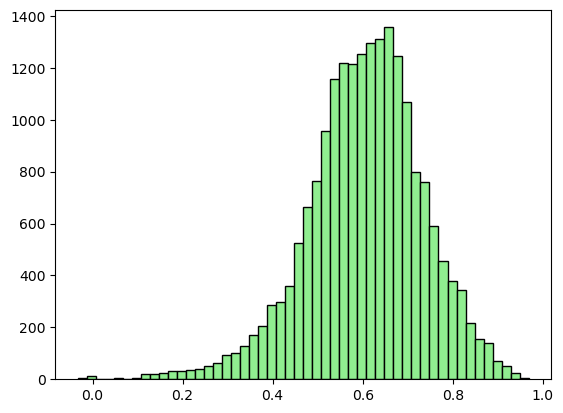

In [59]:
plt.hist(query_passage_test["predicted_score"], color='lightgreen', ec='black', bins=50)

# Evaluate using MRR@10

In [46]:
query_passage_test[query_passage_test["query_id"] == 203324]

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned,qvector,passage,passage_cleaned,passage_cleaned_lemmatized,pvector,predicted_score
15,203324,him functions to the paper health record,Q0,msmarco_passage_07_257313185,96,8.957400,Anserini,0,him functions to the paper health record,"[0.14556085817996958, 0.13481659327905138, 0.2...",new\nMedical Records Specialist I. Confluence ...,new medical records specialist i confluence he...,new medical record specialist confluence healt...,"[-0.0647021687546891, 0.16967883741221348, 0.1...",0.741666
8,203324,him functions to the paper health record,Q0,msmarco_passage_58_723159152,9,10.833700,Anserini,1,him functions to the paper health record,"[0.10906402841840133, 0.07147798942794618, 0.1...",7 Jobs You Can Get With a Health Information M...,jobs you can get with a health information ma...,job health information management degree han...,"[-0.06610817609554387, 0.13036794896313456, 0....",0.721488
12,203324,him functions to the paper health record,Q0,msmarco_passage_65_238890762,93,8.977200,Anserini,0,him functions to the paper health record,"[0.18478877489705367, 0.02280858236116523, 0.2...",Other cost savings are achieved by the elimina...,other cost savings are achieved by the elimina...,cost saving achieve elimination paper printer ...,"[0.0014475258209636032, 0.19414255791394375, 0...",0.713467
13,203324,him functions to the paper health record,Q0,msmarco_passage_17_178380607,94,8.974700,Anserini,0,him functions to the paper health record,"[0.1890691528790081, 0.013692974372747682, 0.2...",Electronic Health Record (EHR) Implementation ...,electronic health record ehr implementation ea...,electronic health record ehr implementation ea...,"[-0.007589344192180946, 0.09946228971929201, 0...",0.711175
1,203324,him functions to the paper health record,Q0,msmarco_passage_26_450017756,2,11.853700,Anserini,1,him functions to the paper health record,"[0.16058261150480324, 0.08438057057848884, 0.2...",Hybrid Health Record. Electronic Health Record...,hybrid health record electronic health records...,hybrid health record electronic health record ...,"[0.055400573858126724, 0.23472551727098237, 0....",0.692155
16,203324,him functions to the paper health record,Q0,msmarco_passage_53_560231782,97,8.947300,Anserini,0,him functions to the paper health record,"[0.1636845003861664, 0.0029619517806671763, 0....",AHIMA adds to this description by saying HIM p...,ahima adds to this description by saying him p...,ahima add description say personnel help conne...,"[-0.03816305240916281, 0.18103433271662914, 0....",0.689244
10,203324,him functions to the paper health record,Q0,msmarco_passage_18_714845189,91,9.005599,Anserini,0,him functions to the paper health record,"[0.1867707185613978, 0.09745332798510309, 0.22...",Comparison with paper-based records. While the...,comparison with paper based records while ther...,comparison paper base record considerable deba...,"[-0.006716908399502517, 0.09474732822849165, 0...",0.688474
6,203324,him functions to the paper health record,Q0,msmarco_passage_11_636220699,7,10.946800,Anserini,1,him functions to the paper health record,"[0.18985035645174747, 0.01872387473456833, 0.2...","Learn common pharmacology, diagnostics, case p...",learn common pharmacology diagnostics case pre...,learn common pharmacology diagnostic case pres...,"[0.008020251160283546, 0.16039972096353589, 0....",0.681626
9,203324,him functions to the paper health record,Q0,msmarco_passage_24_583711786,10,10.766200,Anserini,1,him functions to the paper health record,"[0.0762533539518305, 0.09834150556404009, 0.20...",That includes all paper records and electronic...,that includes all paper records and electronic...,include paper record electronic health record ...,"[-0.01870652664512174, 0.16913363083475216, 0....",0.671876
2,203324,him functions to the paper health record,Q0,msmarco_passage_19_202396335,3,11.273800,Anserini,1,him functions to the paper health record,"[0.11474029513

In [49]:
dict_qid_all_pid_prediction = {}

for qid, group in query_passage_test.groupby('query_id'):
    dict_qid_all_pid_prediction[qid] = group['passage_id'].values.tolist()

In [50]:
topn = 10
mrr = 0.0
qids = []
rrs = []

# iterate over all the qid (keys in the dictionary)
for qid in dict_qid_all_pid_prediction:

    rr = 0.0
    
    # iterate over all the element of topn pid [pid1, pid2, ... pid topn]
    for i, pid in enumerate(dict_qid_all_pid_prediction[qid][: topn + 1]):

        # check if the pid has relenvace > 0
        if qid in dict_of_dict_qid_pid_rel and pid in dict_of_dict_qid_pid_rel[qid] and dict_of_dict_qid_pid_rel[qid][pid] > 0:
        
            rr = 1 / (i+1)
        
            break
    qids.append(qid)
    rrs.append(rr)
    mrr += rr
mrr /= len(dict_qid_all_pid_prediction)
print("MRR@10: ", mrr)

MRR@10:  0.7564457070707081


# Evaluate using MAP@10

In [53]:
result = query_passage_test

In [54]:
# Function for calculating average precision for a query
def average_precision(qid, topn = 10):
    
    # ========= for each query_id, do the following:
    #print(f"Started to work on query_id {qid}")
    # get passage_id (each query_id would have upto 10 passage_id)
    qresult = result.loc[result["query_id"] == qid, ["passage_id", "rel", "predicted_score"]]


    
    # sort rows so that passages with the highest similarity ranks as top 
    qresult.sort_values(by="predicted_score", ascending = False, inplace=True)

    # # Taking Top 10 documents for the evaluation
    ranking = qresult.head(topn)['rel'].values
    #display(qresult.head(topn))
    
    # # Calculating precision
    precision=[]
    for i in range(1,11):
      if ranking[i-1]:
        precision.append(np.sum(ranking[:i])/i)
    
    # If no relevant document in list then return 0
    if precision==[]:
      return 0
    #print(len(precision))
    #print(precision)
    avg_precision = np.mean(precision)
    #print("Avg precision: {}".format(avg_precision))
    return avg_precision#, len(precision), qresult.shape[0]

In [55]:
result["avg_precision"] = result.apply(lambda x: average_precision(x['query_id'])
                                    ,axis=1)

In [56]:
print('Mean Average Precision=>', result["avg_precision"].mean())

Mean Average Precision=> 0.684940964191232


In [ ]:
# result.drop(columns = ["vector"]).to_csv("./output/query_test_w2v_result.csv", index = False)